<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Retail Customer Clustering

### Overview
The dataset given is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts.

### Business Goal
We aim to segment the Customers based on RFM so that the company can target its customers efficiently.

The RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

### Data

You are given a dataset: each row represents a transaction (so, if a given customer buys a t-shirt and socks you will have one row for the t-shirt and one row for the socks).

+ InvoiceNo: id of the invoice
+ StockCode: id of the given clothing
+ Description: description of the clothing item
+ Quantity: quantity purchased
+ InvoiceDate: date of the purchase
+ UnitPrice: unit price of the clothing item
+ CustomerID: id of the customer
+ Country: country of the customer


You are asked to **develop a clustering algorithm** to be able to group clients based on their RFM:

+ Recency: days from their last purchase
+ Frecuency: how many times per month/week they buy
+ Monetary: how much is their average ticket

### Business questions

1. **How many groups of customers do we have** 
2. **Which is their profile**


### Steps

You can follow those **steps** :
1. *Explore* and understand the dataset. 
2. Data Cleansing
3. Data preparation (RFM)
4. Assess number of clusters
5. Build clusters
6. Profiling of each cluster: how often they buy, how much, are them a high value group or a low value?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import numpy as np
import statistics


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Import dataset
df = pd.read_csv("retail_data.csv",encoding = 'unicode_escape')

In [ ]:
def country_analysis(x):
    return x.value_counts()

def IQROutlier(data):
    Q1 = np.nanpercentile(data, 25)
    Q3 = np.nanpercentile(data, 75)
    IQR = Q3 - Q1
    lowerbound = Q1 - (IQR*3)
    upperbound = Q3 + (IQR*3)

    outliers = []
    for i in data:
        if i > upperbound or i < lowerbound:
            outliers.append(1)
        else:
            outliers.append(0)
    return outliers

def LocalizedOutlier(columnname, granularity, dataset):
    outliers = pd.DataFrame()
    for code in df['{}'.format(granularity)].unique():
        temp = df[df['{}'.format(granularity)] == code].copy()
        temp['{}_out'.format(columnname)] = IQROutlier(temp['{}'.format(columnname)])
        temp['mean'] = np.mean(temp['{}'.format(columnname)])
        temp['median'] = np.median(temp['{}'.format(columnname)])
        temp['ncount'] = len(temp['{}'.format(columnname)])
        temp['std'] = np.std(temp['{}'.format(columnname)])
        outliers = pd.concat([outliers, temp], ignore_index = True)
    return outliers

# Step 1: Explore and Understand Dataset

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Step 2: Data Cleansing

## Null Handling

#### Per the output above, we mainly notice nulls in Description and CustomerID. Description data will not be used in our analysis so we focus our efforts in seeing if we can impute CustomerID using InvoiceNo. If an InvoiceNo is tied to a CustomerID, use that CustomerID for rows associated with that InvoiceNo but have no Customer ID.

In [ ]:
# Do NOT run this loop !!! (takes a long time)
# Was made just to prove there are no Invoices that are missing a customer ID 
# and therefore we cannot impute CustomerID
for invoice in df.InvoiceNo.unique():
    customer = df[df['InvoiceNo'] == invoice].CustomerID.unique()
    if len(customer) > 1:
        print(invoice)

In [ ]:
# Since we do not have enough information to impute, we decide to drop rows that have no customerID
df = df.dropna(subset = 'CustomerID')

## Outlier Analysis

In [ ]:
# Yay! no 0 quanities
df[df['Quantity'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [ ]:
# remove matchable returns from the dataset (negative quantities)
## We match transactions with negative quantities to transactions with the same StockCode, UnitPrice, and CustomerID. 
## We drop transactions that matched with each other from the main dataset. Since this will mess with the Monetary section of the model
## if multiple matches are returned, we pick the first one to be dropped.

df_negative = df.loc[df['Quantity'] < 0]
dropped_transactions = 0
for index, row in df_negative.iterrows():
    drop_options = df[(df['StockCode']==row['StockCode'])&(df['UnitPrice']==row['UnitPrice'])&(df['Quantity']+row['Quantity']==0)
            &(df['CustomerID']==row['CustomerID'])]
    if len(drop_options) > 0:
        df.drop(index, inplace = True, axis = 0)
        df.drop(drop_options.index[0], inplace = True, axis = 0)
        dropped_transactions = dropped_transactions + 1
            
print('transactions dropped:', dropped_transactions)        

transactions dropped: 3072


In [ ]:
# 2 situations with unit price that could affect our analysis (transactions with Manual in the Description and 0s)
# Fill 0 Unit Price with mode of its associated StockCode
df[df['UnitPrice'] == 0]
for code in df.StockCode.unique():
    df.UnitPrice.replace({0:statistics.mode(df[df['StockCode'] == code].UnitPrice)}, inplace = True)
    
#Transactions with 'Manual' in the Description seem to be fixing errouneous transaction entries so we keep it.

In [ ]:
# quantity outliers per customer (is a customer a retailer?)
df_CustIDOut = LocalizedOutlier('Quantity', 'CustomerID', df)
# didn't find much with this

In [ ]:
#Main outliers in UnitPrice are mainly associated with the 'Manual' description so we keep them
df['UPOut'] = IQROutlier(df.UnitPrice)

# Step 3: Data Preparation

In [ ]:
df.CustomerID = df.CustomerID.astype(int)
df_clean_copy = df.copy()

## Feature Creation

### Recency

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).apply(lambda x: x.date())

#Maximum and Minimum Invoice Date Per customer
df_cust_recency = pd.merge(df.groupby('CustomerID')['InvoiceDate'].min().reset_index(), 
                      df.groupby('CustomerID')['InvoiceDate'].max().reset_index(), 
                      left_on = 'CustomerID', right_on = 'CustomerID', suffixes=('_min', '_max'))

df_cust_recency['InvoiceDate_max'] = pd.to_datetime(df_cust_recency['InvoiceDate_max'])
df_cust_recency['InvoiceDate_min'] = pd.to_datetime(df_cust_recency['InvoiceDate_min'])

#Days Since Last Purchase (compared to last day of 2011)
df_cust_recency['DaysSinceLastPurchase'] = datetime(2011, 12, 31) - df_cust_recency['InvoiceDate_max']

#Customer Duration
df_cust_recency['CustomerDuration'] = df_cust_recency['InvoiceDate_max'] - df_cust_recency['InvoiceDate_min']


df_cust_recency['DaysSinceLastPurchase'] = df_cust_recency['DaysSinceLastPurchase'].apply(lambda x: int(x.days))
df_cust_recency['CustomerDuration'] = df_cust_recency['CustomerDuration'].apply(lambda x: int(x.days))

### Frequency

In [ ]:
## Average how many times a month they buy

df_cust_freq = df.groupby(['CustomerID','InvoiceNo'])['InvoiceDate'].max().reset_index()
df_cust_freq['Month'] = df_cust_freq['InvoiceDate'].apply(lambda x: int(x.month))
df_cust_freq['Year'] = df_cust_freq['InvoiceDate'].apply(lambda x: int(x.year))
df_cust_month_freq_count = df_cust_freq.groupby(['CustomerID', 'Month', 'Year'])['InvoiceNo'].count().reset_index()
df_cust_month_freq_sum = df_cust_month_freq_count.groupby(['CustomerID', 'Month'])['InvoiceNo'].mean().reset_index()
df_freq = df_cust_month_freq_sum.groupby('CustomerID')['InvoiceNo'].mean().reset_index()


## Average days betwen purchases and how many times a week do they buy

avgdatesbn = []
weeks = []
for customer in df.CustomerID.unique():
    dates = pd.to_datetime(df_cust_freq[df_cust_freq['CustomerID'] == customer].InvoiceDate)
    dates = list(set(dates))
    dates.sort()
    deltas = []
    weekcount = []
    wc = 0
    for date in range(0,len(dates)):
        
        if not dates[date] == dates[-1]:
            tdelta = dates[date+1] - dates[date]
            tdelta = int(tdelta.days)
            deltas.append(tdelta)
            if not tdelta <= 7:
                weekcount.append(1)
            else:
                wc = wc + 1
        else:
            tdelta = 0
            deltas.append(tdelta)
            weekcount.append(1)
    if wc != 0:
        weekcount.append(wc)
    avgdatesbn.append(statistics.mean(deltas))
    weeks.append(statistics.mean(weekcount))

df_freq['AverageDaysBNPurchases'] = avgdatesbn
df_freq['AveragePurchasesPerWeek'] = weeks

4361


### Monetary

In [ ]:
#Transaction Cost
df_clean_copy['TransactionCost'] = df_clean_copy['Quantity'] * df_clean_copy['UnitPrice']
df_transactions = pd.DataFrame()
df_transactions['InvoiceTotal'] = df_clean_copy.groupby(['InvoiceNo','CustomerID'])['TransactionCost'].sum()

#Average Spend Per Invoice By Customer
df_features = pd.DataFrame()
df_features['AvgSpendPerInvoiceByCustomer'] = df_transactions.groupby('CustomerID')['InvoiceTotal'].mean()

#Number of Invoices Per Customer
df_features['NumberInvoiceByCustomer'] = df_clean_copy.groupby('CustomerID')['InvoiceNo'].count()

#Average Quantity Per Invoice
df_features['AverageQuantityByCustomer'] = pd.merge(df_clean_copy.groupby('InvoiceNo')['Quantity'].mean().reset_index(), 
                                                    df_clean_copy[['InvoiceNo', 
                                                                   'CustomerID']]).groupby('CustomerID')['Quantity'].mean()

In [ ]:
#combine datasets
df_features.reset_index()
df_features = pd.merge(df_features, df_cust_recency, left_on='CustomerID', right_on='CustomerID')
df_features = pd.merge(df_features, df_freq, left_on = 'CustomerID', right_on = 'CustomerID')
df_features.drop(columns = ['InvoiceDate_min', 'InvoiceDate_max'], axis = 1, inplace = True)

In [ ]:
df_features

,CustomerID,AvgSpendPerInvoiceByCustomer,NumberInvoiceByCustomer,AverageQuantityByCustomer,DaysSinceLastPurchase,CustomerDuration,InvoiceNo,AverageDaysBNPurchases,AveragePurchasesPerWeek
0,12347,615.714286,182,13.505495,61,476,1.10,209.333333,1.000000
1,12348,449.310000,31,75.516129,97,283,1.00,46.428571,1.555556
2,12349,1757.550000,73,8.643836,40,0,1.00,43.562500,1.333333
3,12350,334.400000,17,11.588235,332,0,1.00,134.500000,1.000000
4,12352,220.772857,75,6.266667,94,268,1.75,104.500000,1.000000
...,...,...,...,...,...,...,...,...,...
4356,18280,180.600000,10,4.500000,181,0,1.00,0.000000,1.000000
4357,18281,80.820000,7,7.714286,25,0,1.00,0.000000,1.000000
4358,18282,58.866667,13,7.538462,114,208,1.00,0.000000,1.000000
4359,18283,130.930000,756,1.847884,31,311,2.00,0.000000,1.000000


In [ ]:
# We are only clustering using the RFM Model: Days since last purchase, Average spend per ticket, 
# and how many times a month/week they buy.
clustercols = ['CustomerID', 
               'DaysSinceLastPurchase', 
               'AvgSpendPerInvoiceByCustomer',
               'InvoiceNo',
              'AveragePurchasesPerWeek']

df_cluster = df_features[clustercols].rename(columns = {'InvoiceNo':'AverageNumTicketsPerMonth'})

#Outlier purchase creating its own cluster
df_cluster.drop(df_cluster[df_cluster['CustomerID'] == 13256].index, inplace = True)

# Step 4: Assess Number of Clusters

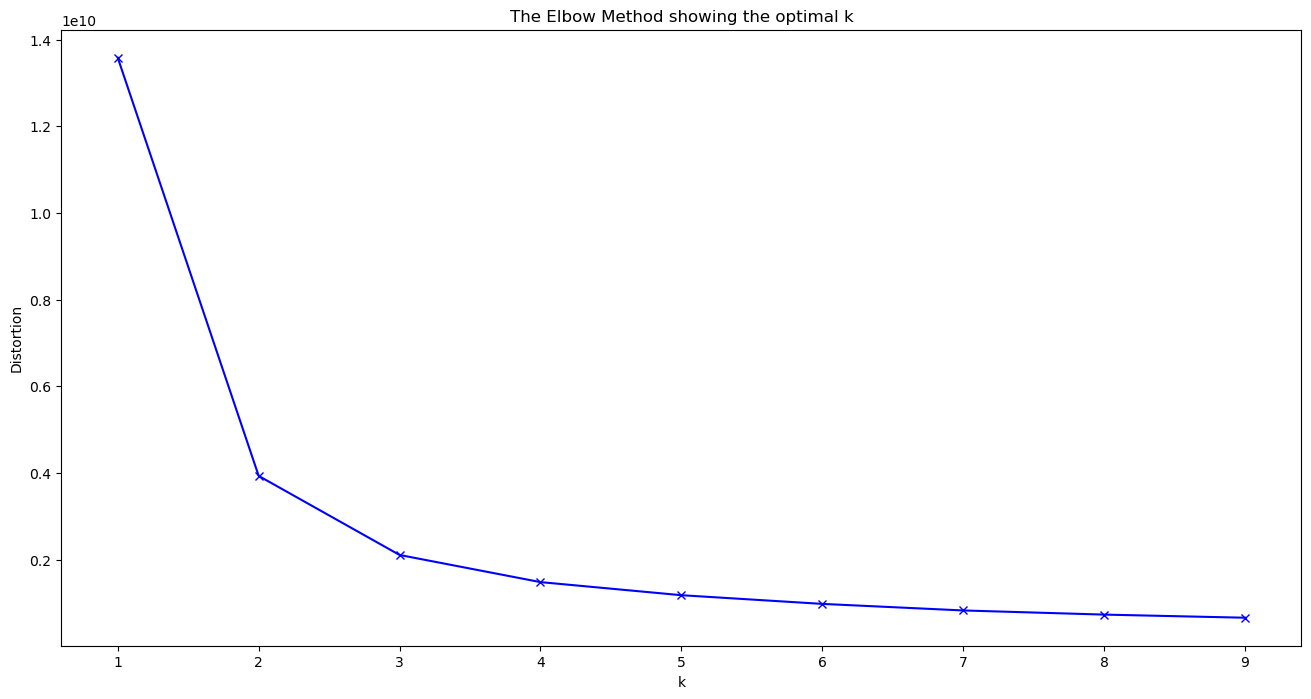

In [ ]:
#test kmeans model across varying ks
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_cluster)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Step 5: Build clusters

In [ ]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(df_cluster)
df_cluster['pred_cluster'] = kmeanModel.predict(df_cluster)

In [ ]:
df_cluster['pred_cluster'].value_counts()

2    1467
0    1447
1    1446
Name: pred_cluster, dtype: int64

## Step 6: Profiling of each cluster

### Cluster 1

In [ ]:
pd.merge(df_cluster[df_cluster['pred_cluster'] == 0], df_features).describe()

,CustomerID,DaysSinceLastPurchase,AvgSpendPerInvoiceByCustomer,AverageNumTicketsPerMonth,AveragePurchasesPerWeek,pred_cluster,NumberInvoiceByCustomer,AverageQuantityByCustomer,CustomerDuration,InvoiceNo,AverageDaysBNPurchases
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.0,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,13309.731859,120.478922,376.390293,1.273595,1.095297,0.0,90.446441,20.469537,169.988252,1.273595,60.833247
std,573.177002,111.428388,442.037627,0.598478,0.512425,0.0,224.547810,121.930445,174.063944,0.598478,57.118087
min,12347.000000,21.000000,-1192.200000,1.000000,1.000000,0.0,1.000000,-48.800000,0.000000,1.000000,0.000000
25%,12800.000000,41.000000,169.571923,1.000000,1.000000,0.0,18.000000,7.301599,0.000000,1.000000,23.844444
50%,13304.000000,78.000000,276.698000,1.000000,1.000000,0.0,41.000000,10.460000,142.000000,1.000000,47.000000
75%,13811.500000,173.000000,447.839375,1.375000,1.000000,0.0,98.500000,14.872416,282.000000,1.375000,81.414286
max,14307.000000,718.000000,6207.670000,11.416667,14.000000,0.0,5128.000000,4300.000000,697.000000,11.416667,337.500000


### Cluster 2

In [ ]:
pd.merge(df_cluster[df_cluster['pred_cluster'] == 1], df_features).describe()

,CustomerID,DaysSinceLastPurchase,AvgSpendPerInvoiceByCustomer,AverageNumTicketsPerMonth,AveragePurchasesPerWeek,pred_cluster,NumberInvoiceByCustomer,AverageQuantityByCustomer,CustomerDuration,InvoiceNo,AverageDaysBNPurchases
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.0,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,17292.025588,127.071923,286.162160,1.290170,1.004883,1.0,91.209544,21.178373,169.192946,1.290170,20.637674
std,575.615184,120.225476,319.438582,0.617934,0.044142,0.0,237.476021,92.144339,179.833339,0.617934,33.318511
min,16302.000000,21.000000,-4287.630000,1.000000,1.000000,1.0,1.000000,-144.000000,0.000000,1.000000,0.000000
25%,16788.250000,41.000000,149.036250,1.000000,1.000000,1.0,16.000000,4.435220,0.000000,1.000000,0.000000
50%,17301.500000,81.000000,224.577500,1.000000,1.000000,1.0,40.000000,8.787108,132.000000,1.000000,0.000000
75%,17786.750000,181.000000,344.115833,1.437500,1.000000,1.0,101.000000,13.568571,282.500000,1.437500,32.000000
max,18287.000000,718.000000,4314.720000,11.666667,1.700000,1.0,7759.000000,2140.000000,697.000000,11.666667,161.000000


### Cluster 3

In [ ]:
pd.merge(df_cluster[df_cluster['pred_cluster'] == 2], df_features).describe()

,CustomerID,DaysSinceLastPurchase,AvgSpendPerInvoiceByCustomer,AverageNumTicketsPerMonth,AveragePurchasesPerWeek,pred_cluster,NumberInvoiceByCustomer,AverageQuantityByCustomer,CustomerDuration,InvoiceNo,AverageDaysBNPurchases
count,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000,1467.0,1467.000000,1467.000000,1467.000000,1467.000000,1467.000000
mean,15305.810498,121.764145,317.898633,1.284713,1.021234,2.0,94.014315,18.409011,168.151329,1.284713,34.072156
std,572.587452,112.038705,353.714688,0.639448,0.087919,0.0,222.193104,81.377816,181.483376,0.639448,31.956496
min,14304.000000,21.000000,-1592.490000,1.000000,1.000000,2.0,1.000000,-26.000000,0.000000,1.000000,0.000000
25%,14809.000000,41.000000,159.309167,1.000000,1.000000,2.0,17.000000,5.280612,0.000000,1.000000,0.000000
50%,15306.000000,76.000000,252.051667,1.000000,1.000000,2.0,42.000000,9.538462,130.000000,1.000000,31.666667
75%,15796.500000,171.000000,370.905000,1.408333,1.000000,2.0,101.000000,13.986111,280.000000,1.408333,52.833333
max,16303.000000,718.000000,7178.633333,14.166667,2.090909,2.0,5647.000000,1756.500000,697.000000,14.166667,163.000000


#### How often they buy, how much, are they a high value group or a low value?

##### With the RFM model requested by the client, the clusters are very similar in terms of their average RFM values. Meaning the group sizes and average values for the RFM features are similar. Therefore, we added more features to see if we could notice any trends in other noteworthy characteristics. 

##### Cluster 1: From the RFM Model this cluster has the highest average spend per ticket and most recent average days since last purchase, however it has the smallest average number of tickets per month. Based on this we deduce these are are high value but infrequent customers. Alternatively, this cluster could be reflective of christmas shoppers due to the high average spend per ticket and having the earliest recency from our other clusters (recency features were based on distance from 12/31/2011).
##### Cluster 2: From the RFM Model this cluster has the highest average monthly frequency but the lowest average spend per ticket. From our auxiliary features it has the highest average quantity of items purchased and least average days between purchases. Based on this we deduce these low value but frequent customers. 
##### Cluster 3: From the RFM Model this cluster has the second highest average spend per ticket. It also has the highest average number of tickets per month. From our auxiliary features it has the highest average number of ticket by customer. Based on this we deduce these are high value and high frequency customers. 

### Business Questions

#### How many groups of customers do we have?
##### Based on the RFM model there are 3 groups of customers.

#### Which is their profile?
##### Cluster 1: Customers with the highest ticket values but lowest frequency. 
##### Cluster 2: Customers with the lowest ticket values but highest frequency.
##### Cluster 3: Customers with high ticket values and high frequency. Our best customers!